In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)
from scipy.stats import gaussian_kde, gamma, lognorm, entropy
import scipy.stats
import pandas as pd

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params_aniso, NODE_model_aniso
from utils import train_jp, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_diffusion import *

In [64]:
# Post process the outputs of 'cluster_mice_w_sensitivity.py'. 
# Errors
init = 1
n_neurons_list = np.arange(1,10)*5+11
init_list = [1,2,3,4,5,6,7,8,9,10]
n_samples = 15

allerrors = np.empty([len(n_neurons_list),len(init_list),n_samples],dtype=object)
kl_symm = np.zeros_like(allerrors)
tvds = np.zeros_like(allerrors)
for n, n_neurons in enumerate(n_neurons_list):
    for init in init_list:
        filename = f"params/mice_w_sensitivity/errors_width_{n+2}_init_{init}.npy"
        allerrors[n, init-1] = np.array(np.load(filename, allow_pickle=True))

        filename = f"params/mice_w_sensitivity/kl_symm_width_{n+2}_init_{init}.npy"
        kl_symm[n, init-1] = np.array(np.load(filename, allow_pickle=True))


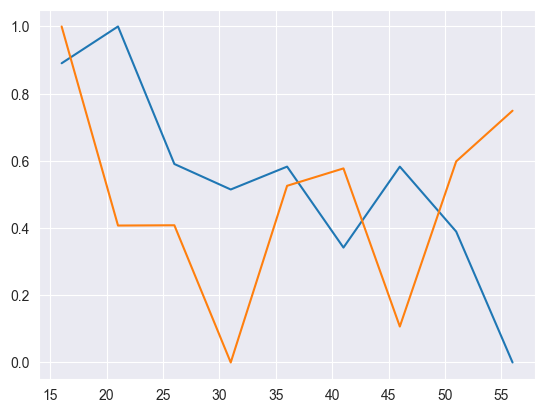

In [65]:
def normalize(x):
    x = x - np.min(x)
    return x/np.max(x)
def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zero(len(d))
    return data[s<m]

fig, ax = plt.subplots()
err_means = np.mean(allerrors.reshape(9,-1), axis=1)
ax.plot(n_neurons_list, normalize(err_means))

np.savetxt('tikz/fig_mice_w_sensitivity_data/errors.csv',   np.vstack([n_neurons_list,  err_means]).T)

In [6]:
def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zero(len(d))
    return data[s<m]

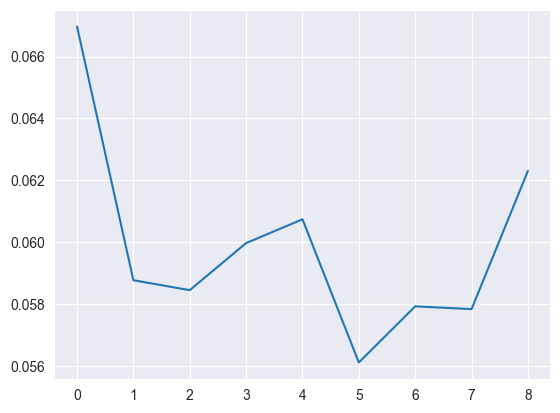

In [66]:
# compute the distance
with open('params/mice_w_sensitivity/data_stat.npy', 'rb') as f:
    data_stat = pickle.load(f)
dist = []
for n, n_neurons in enumerate(n_neurons_list):
    aux = []
    for init in init_list:
        filename = f"params/mice_w_sensitivity/model_stat_width_{n+1}_init_{init}.npy"
        dist_i = reject_outliers(np.array(np.load(filename, allow_pickle=True)), m=1)
        # dist_i = np.load(filename, allow_pickle=True)
        aux.append(scipy.stats.energy_distance(data_stat, dist_i))
    dist.append(np.mean(reject_outliers(np.array(aux),m=2)))
plt.plot(dist)
np.savetxt('tikz/fig_mice_w_sensitivity_data/energy_dist.csv', np.vstack([n_neurons_list,  dist]).T)

In [67]:
print(np.min(dist), np.max(dist))

0.05611474655541659 0.06697397007582195


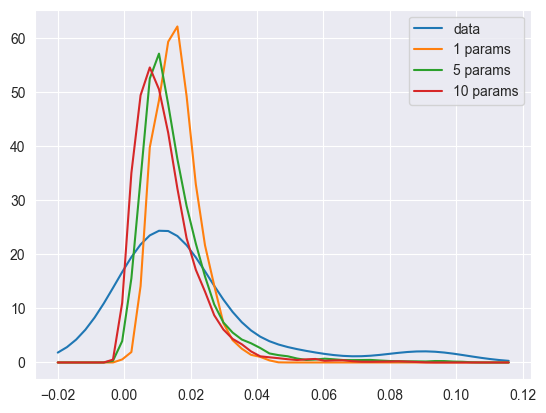

In [18]:
with open('params/mice_w_sensitivity/data_stat.npy', 'rb') as f:
    data_stat = pickle.load(f)

model_stat_low = []
model_stat_med = []
model_stat_hgh = []
n_neurons = 2
for init in init_list:
    filename = f"params/mice_w_sensitivity/model_stat_width_1_init_{init}.npy"
    model_stat_low.append(reject_outliers(np.array(np.load(filename, allow_pickle=True))))

    filename = f"params/mice_w_sensitivity/model_stat_width_5_init_{init}.npy"
    model_stat_med.append(reject_outliers(np.array(np.load(filename, allow_pickle=True))))

    filename = f"params/mice_w_sensitivity/model_stat_width_10_init_{init}.npy"
    model_stat_hgh.append(reject_outliers(np.array(np.load(filename, allow_pickle=True))))
model_stat_low = np.hstack(model_stat_low)
model_stat_med = np.hstack(model_stat_med)
model_stat_hgh = np.hstack(model_stat_hgh)

data_kde = gaussian_kde(data_stat)
xmin = np.min(data_stat)
xmax = np.max(data_stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
qk = data_kde(x)


model_kde_low = gaussian_kde(model_stat_low)
model_kde_med = gaussian_kde(model_stat_med)
model_kde_hgh = gaussian_kde(model_stat_hgh)
pk_low = model_kde_low(x)
pk_med = model_kde_med(x)
pk_hgh = model_kde_hgh(x)

plt.plot(x, qk, label='data')
plt.plot(x, pk_low, label='1 params')
plt.plot(x, pk_med, label='5 params')
plt.plot(x, pk_hgh, label='10 params')
plt.legend()

data = np.array([x*1000, qk, pk_low, pk_med, pk_hgh]).T
np.savetxt('tikz/fig_mice_w_sensitivity_data/stat_densities.csv', data, header='x y_gt y_low y_med y_high', comments='')

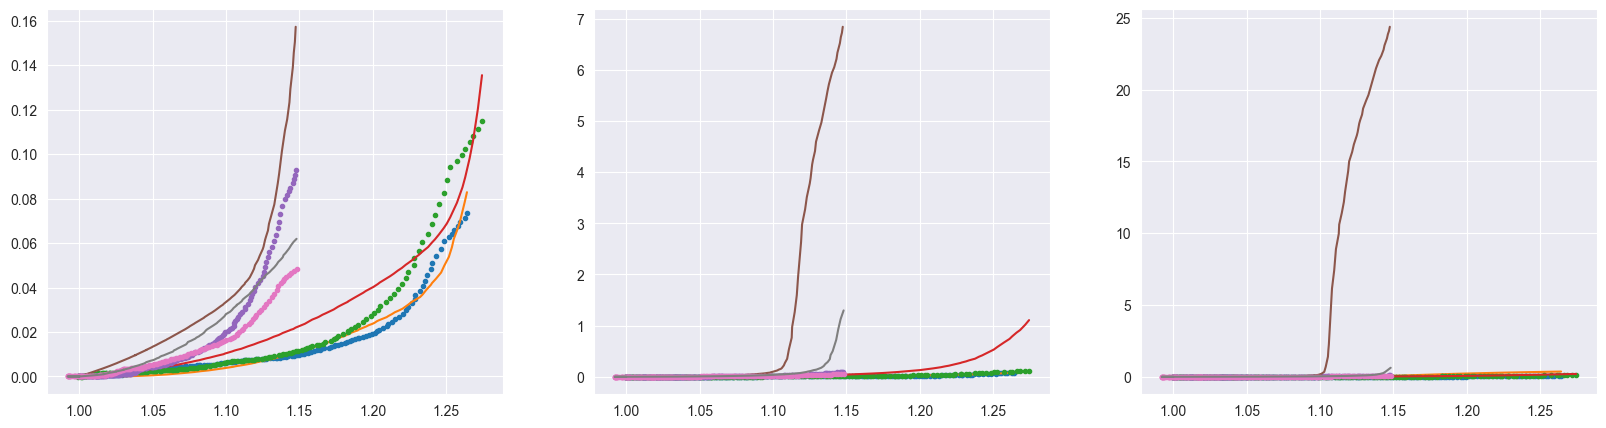

In [22]:
# Export the stress plots
murine_data = pd.read_csv('data/murine_data.csv')
J = np.max(np.unique(murine_data.ID))
fig, ax = plt.subplots(1,3,figsize=(20,5))

for i, n_neurons in enumerate([1,5,10]):
    out = []
    with open('params/mice_w_sensitivity/params_m_' + str(n_neurons) + '_init_4.npy', 'rb') as f:
        params_all = pickle.load(f)

    with open('params/mice_w_sensitivity/params_s_width_' + str(n_neurons)+ '_init_4.npy', 'rb') as f:
        Sample_params = pickle.load(f)
    
    for j in range(4):
        sample_params = Sample_params[j]
        params = merge_weights_aniso(params_all, sample_params)
        mymodel = NODE_model_aniso(params)
        
        
        lamb_sigma_j = murine_data[(murine_data.ID==j)&(murine_data.test==2)][['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy()
        sgmx_pr, sgmy_pr = eval_Cauchy_aniso_vmap(lamb_sigma_j[:,0],lamb_sigma_j[:,1], mymodel)

        ax[i].plot(lamb_sigma_j[:,0], lamb_sigma_j[:,2], '.')
        ax[i].plot(lamb_sigma_j[:,0], sgmx_pr)

        out = np.array([lamb_sigma_j[:,0], lamb_sigma_j[:,2]*1000, sgmx_pr*1000])
        np.savetxt('tikz/fig_mice_w_sensitivity_data/stress_' + str(n_neurons) + '_' + str(j) + '.csv', out.T, header = 'x y_gt y_pr', comments = '')
        

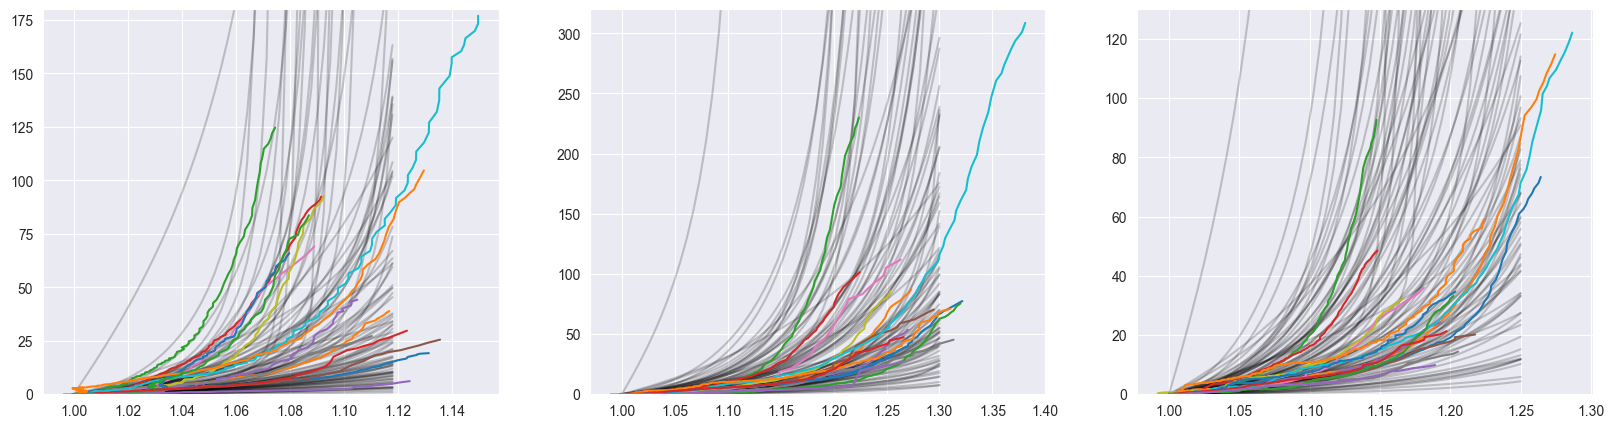

In [7]:
# The next figure (All stress data against diffusion)
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].set(ylim = [-0.005, 180])
ax[1].set(ylim = [-0.01, 320])
ax[2].set(ylim = [-0.01, 130])
header = [' y_' + str(i) for i in range(100)]
header = 'x' + ' '.join(header)


t2t = ['offx', 'offy', 'equi']
# Plot the predicted data
lmbx = np.sqrt(np.linspace(1,1.25))
with open('params/mice_w_sensitivity/model_sgm_offx_width_5_init_4.npy', 'rb') as f:
    model_sgm_offx = pickle.load(f)
model_sgm_offx = np.array(model_sgm_offx)[:,0,:]*1000
model_sgm_offx = model_sgm_offx[:100]
for sgmx_pr in model_sgm_offx:
    ax[0].plot(lmbx, sgmx_pr, 'k', alpha=0.2)
model_sgm_offx = np.clip(model_sgm_offx, a_min=-100, a_max = 1000)
model_sgm_offx = np.vstack([lmbx, model_sgm_offx])
np.savetxt('tikz/fig_mice_stress_data/model_offx.csv', model_sgm_offx.T, header=header, comments='')

lmbx = np.linspace(1,1.3)
with open('params/mice_w_sensitivity/model_sgm_offy_width_5_init_4.npy', 'rb') as f:
    model_sgm_offy = pickle.load(f)
model_sgm_offy = np.array(model_sgm_offy)[:,0,:]*1000
model_sgm_offy = model_sgm_offy[:100]
for sgmx_pr in model_sgm_offy:
    ax[1].plot(lmbx, sgmx_pr, 'k', alpha=0.2)
model_sgm_offy = np.clip(model_sgm_offy, a_min=-100, a_max = 1000)
model_sgm_offy = np.vstack([lmbx, model_sgm_offy])
np.savetxt('tikz/fig_mice_stress_data/model_offy.csv', model_sgm_offy.T, header=header, comments='')

lmbx = np.linspace(1,1.25)
with open('params/mice_w_sensitivity/model_sgm_equi_width_5_init_4.npy', 'rb') as f:
    model_sgm_equi = pickle.load(f)
model_sgm_equi = np.array(model_sgm_equi)[:,0,:]*1000
model_sgm_equi = model_sgm_equi[:100]
for sgmx_pr in model_sgm_equi:
    ax[2].plot(lmbx, sgmx_pr, 'k', alpha=0.2)
model_sgm_equi = np.clip(model_sgm_equi, a_min=-100, a_max = 1000)
model_sgm_equi = np.vstack([lmbx, model_sgm_equi])
np.savetxt('tikz/fig_mice_stress_data/model_equi.csv', model_sgm_equi.T, header=header, comments='')


# Plot the experimental data
for j in range(J):
    for t in range(3):
        lamb_sigma_j = murine_data[(murine_data.ID==j)&(murine_data.test==t)][['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy()
        lamb_sigma_j[:,2] = lamb_sigma_j[:,2]*1000
        ax[t].plot(lamb_sigma_j[:,0], lamb_sigma_j[:,2])
        np.savetxt('tikz/fig_mice_stress_data/data_' + str(j) + '_' + t2t[t] + '.csv', lamb_sigma_j[:,[0,2]])